In [18]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras import backend as K


In [19]:
class AutoCNN():
    
    '''
    Vector Autoregression model

    Attributes
    ----------
    self.data_backup: dataframe, a backup copy of the input dataset
    self.data: dataframe, the main dataset worked on
    self.n: int, length (unit in months) of target to predict
    self.df_result: dataframe, stores the predicted target and the true target
    self.lag: int, number of past months used to predict the target
    self.rmse: rounded RMSE of the prediction
    self.target: str, name of target variable
    self.model: record a CNN trained model
    self.train_result: record model fit result loss
    
    Params
    ----------
    data_name: str, name of the dataset. Notice the input dataset must contain a column named 'Date'
    target_name: str, name of target variable
    drop_cols: list of strings, names of columns to drop
    '''
    def __init__(self, data_name, target_name, drop_cols=['Date']):   
        #import data
        curr_path = os.getcwd()
        input_path = os.path.join(curr_path, data_name)
        data = pd.read_excel(input_path, engine='openpyxl',)
        
        #drop columns and na
        drop_cols.remove('Date')
        data.drop(drop_cols, axis=1, inplace=True)
        data.dropna(inplace = True)
        data.reset_index(drop=True, inplace=True)
        
        #set attributes
        self.data_backup = data.copy(deep=False)
        self.data = data.drop(['Date'], axis=1)
        
        self.n = 0
        self.df_result = 0
        self.lag = 0
        self.column_name = []
        self.rmse = 0
        self.target = target_name
        self.n_features = 0
        self.model = 0
        self.train_result = 0

    
    def print_date_range(self):
        #Print Range of Date column
        print('Date Range: ', self.data_backup['Date'].iloc[0], '--', self.data_backup['Date'].iloc[-1])
    
    def flatten_data(self, lag=3, if_target=True):
        ''' Standardize predictors (excluding target itself) and flatten time series dataset
        
        Params
        ----------
        lag: int, num of past months to consider
        if_target: boolean, whether to include target as a predictor
        
        Return
        ----------
        flattened dataset
        '''
        
        #standardize
        withouty = self.data.drop([self.target],axis=1)
        normalizeddata = (withouty - withouty.mean()) / withouty.std()
        normalizeddata[self.target] = self.data[self.target]
        self.data = normalizeddata
        
        new_data = self.data.copy()
        self.lag = lag
        
        for i in range(self.data.shape[1]):
            new_data.columns.values[i] = new_data.columns.values[i] + '_'  + str(0)
            
        for n in range(lag):
            fill_data = self.data.shift(periods = n+1)
            fill_data = fill_data.iloc[n+1:, :]
            new_data = new_data.iloc[1:, :]
            new_data = pd.concat([fill_data, new_data], axis=1)
            # rename added columns
            for i in range(self.data.shape[1]):
                new_data.columns.values[i] = self.data.columns.values[i][:-2] + '_'  + str(n+1)

            #exclude target itself from predictors
            if not if_target:
                name = self.target + '_' + str(n+1)
                new_data.drop([name], axis=1, inplace=True)
                
        self.data = new_data
        self.n_features = int(self.data.shape[1]//(lag+1))
        
    
        
    def run(self, pred_begin_date, n, if_target=True, lags=3): 
        ''' Run CNN
        
        Params
        ----------
        pred_begin_date: date, the begin date of prediction
        n: int, length of prediction (unit in months)      
        lag: int, num of past months to consider
        if_target: boolean, whether to include target as a predictor
        '''
        #flatten dataset
        self.flatten_data(lags, if_target=if_target)
        
        #set attributes
        self.n = n
        test_date_begin = self.data_backup.index[self.data_backup['Date'] == pred_begin_date].tolist()[0] - lags
        train = pd.concat([self.data.iloc[:test_date_begin], self.data.iloc[test_date_begin+n+lags:]], axis=0)
        test = self.data.iloc[test_date_begin:test_date_begin+n]
        train.reset_index(drop=True, inplace=True)
        test.reset_index(drop=True, inplace=True)
        

        
        # find train_y, train_x and test_y, test_x
        train_y = train[self.target + '_0']
        train_x = train.loc[:, self.data.columns[:int(self.n_features*self.lag)]]
        test_y = test[self.target + '_0']
        test_x = test.loc[:, self.data.columns[:int(self.n_features*self.lag)]]

        
        # reshape data and normalize data
        train_x = np.array(train_x).reshape(len(train_x), self.lag, self.n_features, 1)
        test_x = np.array(test_x).reshape(len(test_x), self.lag, self.n_features, 1)
        
        
        #build CNN model
        model = Sequential()
        model.add(Conv2D(filters = 32, 
                         input_shape = ((self.lag, self.n_features,1)),
                         data_format = 'channels_last',
                         kernel_size=(2,2), 
                         strides=(1,1),   
                         activation='relu'))
        #model.add(MaxPooling2D(pool_size=(2, 1)))
        #model.add(AveragePooling2D(pool_size=(2,1)))
        model.add(Flatten())
        model.add(Dense(45, activation='relu'))
        model.add(Dense(1))
        
        def root_mean_squared_error(y_true, y_pred):
            return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))
        model.compile(optimizer='adam', loss=root_mean_squared_error)
        
        result = model.fit(train_x, train_y, verbose=0, validation_data=(test_x, test_y), epochs=20)
        self.model = model
        self.train_result = result

        
        pred_y = self.model.predict(test_x)
        df_result = pd.DataFrame(pred_y, columns=[self.target + '_pred'])
        df_result[self.target] = test_y.values
        df_result['Date'] = self.data_backup['Date'][test_date_begin+self.lag:test_date_begin+self.n+self.lag].values
        df_result.set_index(['Date'],inplace=True)
        self.df_result = df_result
        rmse = mean_squared_error(df_result[self.target + '_pred'], df_result[self.target], squared=False)
        print('RMSE: ', round(rmse,2))
        self.rmse = round(rmse,2)

RMSE:  226.53


<AxesSubplot:xlabel='Date'>

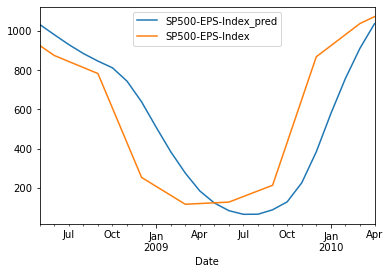

In [23]:
cnn_model = AutoCNN(data_name='test.xlsx', target_name='SP500-EPS-Index', drop_cols=['Date'])
d = '2008-05-01 00:00:00'
n = 24
l = 15
cnn_model.run(pred_begin_date=d, n=n, lags=l, if_target=True)
cnn_model.df_result.plot()


#cnn_model = AutoCNN(data_name='merged_data_1020.xlsx', target_name='SP500-EPS-Index', drop_cols=['Date','SP500-Price','gdp','ManufacturingNewOrders','ConstructionSpending'])
#cnn_model.run(pred_begin_date=d, n=n, lags=l, if_target=False)
#cnn_model.df_result.plot()